In [1]:
from __future__ import division

# !pip uninstall mxnet
# !pip install mxnet-cu100


import argparse, time, logging, random, math
import numpy as np
import mxnet as mx

from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, TrainingHistory
from gluoncv.data import transforms as gcv_transforms
print("Imports Successful!")

Imports Successful!


In [2]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]

# This grabs the CIFAR_ResNet20_v1 with 10 output classses, without
# pre-trained weights.
net = get_model('cifar_resnet20_v1', classes=10)
net.initialize(mx.init.Xavier(), ctx = ctx)
print("Success")

Success


# Data Augmentation and Data Loader
Augmentation is a technique used for training. Based on the assumption that, for the same object, the photos under different composition, lighting condition, or color should yield the same prediction. In this example we will be using different photos of the Golden Gate bridge.

In [3]:
transform_train = transforms.Compose([
    # Randomly crop an area and resize it to be 32x32, then pad it to be 40x40
    gcv_transforms.RandomCrop(32, pad=4),
    #
    transforms.RandomFlipLeftRight(),
    #
    #
    transforms.ToTensor(),
    #
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])
print("Success")

Success


Note that with the training function we have randomized operations. This in effect increases hte number of different images the model sees during training. THe more data we have the better the model generalizes over unseen images.

However, when making predictions we would like to remove all random operations in order to achieve a deterministic result! Therefore, our 
validation/test tranform function is:

Note that we keep the same normalization step since the model works only well on inputs with the same distribution.

In [4]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
])
print("Success")

Success


Now we define data loaders for our training and validation sets

In [5]:
per_device_batch_size = 128
num_workers = 8
batch_size = per_device_batch_size * num_gpus

train_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=True).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard',
    num_workers=num_workers
)

val_data = gluon.data.DataLoader(
    gluon.data.vision.CIFAR10(train=False).transform_first(transform_test),
    batch_size=batch_size, shuffle=False, num_workers=num_workers
)

### Optimizer, Loss, and Metric

In [6]:
lr_decay = 0.1
lr_decay_epoch = [80,160, np.inf]

optimizer = 'nag'
optimizer_params = {'learning_rate':0.1, 'wd':0.0001, 'momentum':0.9}
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [7]:
train_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-error', 'validation-error'])

In [8]:
def test(ctx, val_data):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)
    return metric.get()

### Training Loop

[Epoch 0] train=0.599619 val=0.667600 loss=55808.425766 time: 15.554466


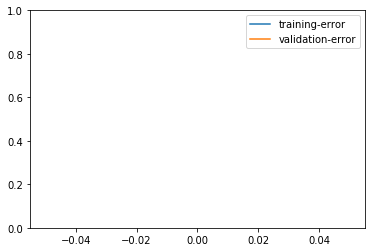

[Epoch 1] train=0.693429 val=0.686000 loss=43411.701836 time: 15.549095


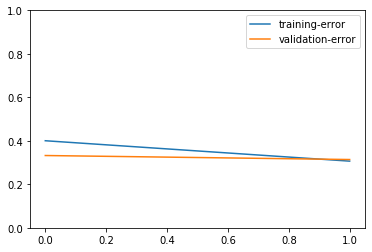

[Epoch 2] train=0.747716 val=0.749300 loss=36160.369637 time: 15.555799


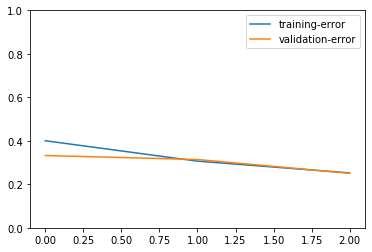

In [10]:
epochs = 3
lr_decay_count = 0

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0
    
    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1
    
    for i, batch in enumerate(train_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = [net(X) for X in data]
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]
        
        # Backpropagation
        for l in loss:
            l.backward()
        
        # Optimize
        trainer.step(batch_size)
        
        # Update metrics:
        train_loss += sum([l.sum().asscalar() for l in loss])
        train_metric.update(label, output)
    
    name, acc = train_metric.get()
    # Evaluate on validation data
    name, val_acc = test(ctx, val_data)
    
    # Update history and print metrics
    train_history.update([1-acc, 1-val_acc])
    print("[Epoch %d] train=%f val=%f loss=%f time: %f" %
        (epoch, acc, val_acc, train_loss, time.time()-tic))

    train_history.plot()

### Model Saving and Loading

In [15]:
net.save_parameters('dive_deep_cifar10_resnet20_v2.params')

In [16]:
# Next time we want to run this model to run a classification, we do the following:
net.load_parameters('dive_deep_cifar10_resnet20_v2.params', ctx=ctx)